In [ ]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 127kB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## Import thư viện

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from joblib import Parallel, delayed
import joblib
import os
from skimage.feature import hog
from skimage.util import random_noise
import warnings
from tqdm import tqdm
from skimage.filters import roberts, sobel
import warnings
warnings.filterwarnings("ignore")
from sklearn import set_config
set_config(display='diagram')


# 1. Tập dữ liệu MNIST

## 1.2.Tải tập dữ liệu

Tải tập dữ liệu NMIST từ bộ dataset có sẵn của thư viện scikit-learn.

In [ ]:
mnist = fetch_openml('mnist_784')

In [ ]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [ ]:
X = X.values

In [ ]:
y= y.values

## 1.3.Chia tập dữ liệu

Bộ dữ liệu này có 70000 mẫu, trong đó chưa được chia thành tập huấn luyện và tập test. Vì vậy ta cũng tự tiền hành chia tập này theo tỉ lệ 1/7 cho bộ test (1000 mẫu), phần còn lại dùng cho mục đích huấn luyện. 

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, random_state=42, test_size=1/7)

In [ ]:
X_.shape

(60000, 784)

In [ ]:
X_test.shape

(10000, 784)

## 1.4.Hiển thị một vài mẫu bất kì

In [ ]:
def plot_sample(X, y, random_state=None):
    rng = np.random.default_rng(seed = random_state)
    selected_ids = rng.choice(np.arange(X.shape[0]), size=25)
    number_image = 5
    f, ax = plt.subplots(number_image,number_image, figsize=(10, 10))

    for i in range(number_image):
        for j in range(number_image):
            pos = selected_ids[i*number_image + j]
            img, label = X[pos,:], y[pos]
            
            ax[i,j].imshow(img.reshape(28, 28), cmap='gray')
            ax[i, j].set_xlabel(f"label: {label}", fontsize=12)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

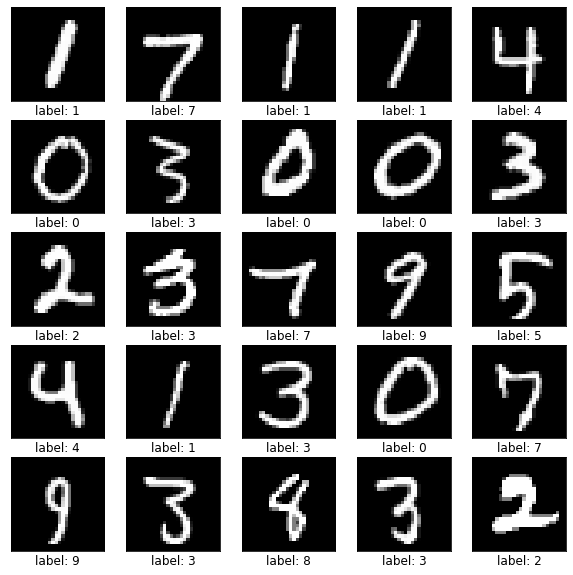

In [ ]:
plot_sample(X, y, random_state=42)

## 1.5. Phân bố dữ liệu



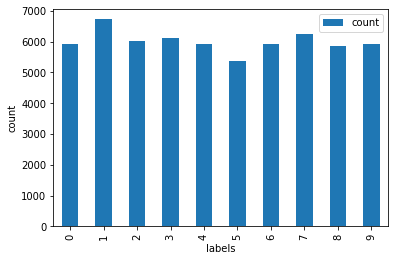

In [ ]:
l, c = np.unique(y_, return_counts=True)
pd.DataFrame(c, columns=['count',], index=l).plot(kind='bar', xlabel='labels', ylabel='count')

Ta thấy trong bộ train này, dữ liệu đã phân bố khá đều, vì thế không cần tiền xử lý phần phân bố dữ liệu lệch nữa.

# 2. Tiền xử lý dữ liệu

## 2.1. Biến đổi dữ liệu đầu ra

Đây là bài toán phân lớp, vì thế kiểu dữ liệu đầu ra không thể là số nguyên được, vì vậy ta sẽ ép kiểu của đầu ra này sang dạng chuỗi, để nó về dạng `categorical`.  
Tuy nhiên dữ liệu này đã ở dạng chuỗi sẵn rồi, nên ta không cần sửa gì thêm.

In [ ]:
y.dtype

CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ordered=False)

## 2.2. Loại bỏ các điểm ảnh vô nghĩa

Đầu tiên ta xác định đâu là điểm ảnh vô nghĩa. Một điểm ảnh vô nghĩa khi ở trong tất cả các mẫu (trong tập huấn luyện khi được fit vào mô hình), các điểm ảnh đó đều có giá trị 0 ở mọi mẫu. Vì nó có giá trị 0 nên sẽ không thể lan truyền tín hiệu nào tới tầng phân lớp ở cuối cùng được.  

Ta có thể bỏ các điểm ảnh này đi để mô hình nhẹ hơn, hoặc là giữ lại thì kết quả cũng sẽ tương đối như nhau.


In [ ]:
class DropUselessCol(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass
    
    def fit(self, X, y=None, classes=None):
      # find pixel which have all 0
      
      self.idx = np.argwhere(np.all(X[..., :] == 0, axis=0)).reshape([-1])
      print("Number of useless pixel detected:", self.idx.shape[0])

      return self
    
    def transform(self, X, y=None):
      X_ = X.copy()
      
      #Remove pixel 0 
      X_ = np.delete(X_, self.idx, axis=1)

      return X_

In [ ]:
drop_pixels = DropUselessCol()
drop_pixels.fit(X_);

Number of useless pixel detected: 68


## 2.3. Đa cộng tuyến

Đa cộng tuyến xảy ra tại mô hình Logistic Regression khi có 2 hay nhiều thuộc tính cùng phụ thuộc vào 1 thuộc tính khác, khi đó 2 thuộc tính này cũng có độ tương quan cao với nhau, nhưng không thể giải thích được.

Giải pháp:  
Mặc dù dùng VIF hoặc độ tương quan để xác định và loại bỏ các cột có đa công tuyến là phù hợp, tuy nhiên chúng lại rất chi phí chạy (đối với bộ dữ liệu này có lên tới hơn 700 thuộc tính), vậy ta sẽ dùng một phương pháp đơn giản khác là PCA.

Nguồn: [https://phantichspss.com](https://phantichspss.com/da-cong-tuyen-dinh-nghia-cach-phat-hien-hau-qua-cach-khac-phuc.html
)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

class MulticollinearityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_vif):
      self.max_vif = max_vif
      self.vifs = None
      pass
    
    def fit(self, X, y=None):
      xr = X.reshape(-1, 28*28)
      
      self.vifs = np.array([VIF(xr, i) for i in range(xr.shape[0])])
      return self

    def transform(self, X, y=None):
      X_ = X[:, self.vifs <= max_vif]

      return X_.apply_along_axis()

In [ ]:
estimator = MulticollinearityTransformer(max_vif=2)

In [ ]:
#arr = estimator.fit_transform(X_train)
#arr.shape

## 2.4. Một số phương pháp khác để tiền xử lý dữ liệu

### Thêm nhiễu vào dữ liệu

Nhiễu là thành phần không đóng góp vào việc nhận dạng các nhãn, tuy nhiên trong thực tế các hình ảnh thường hay có nhiễu. Vì vậy nếu quá trình huấn luyện không bao gồm các dữ liệu có chứa nhiễu, thì có thể trong thực tế ta sẽ gặp và đưa ra dự đoán sai.

Cách để thêm nhiễu vào các mẫu: Ta chỉ cần ngẫu nhiên các điểm ảnh trong mẫu với các giá trị theo một phân phối chuẩn cho trước.

In [ ]:
class Random_Noise_Img(BaseEstimator, TransformerMixin):
    def __init__(self, mean=0., std=5., random_state=None):
        self.std = std
        self.mean = mean
        self.random_state = random_state
        self.rng = np.random.default_rng(seed = random_state)
        pass

    def fit(self, X, y=None):
      return self
    
    def noise_image(self, img_array): # img 1d or 2d
        noisy_img = img_array + self.rng.normal(self.mean, self.std, img_array.shape)
        noisy_img_clipped = np.clip(noisy_img, 0, 255)
        
        return noisy_img_clipped

    def transform(self, X, y=None):
        X_ = np.apply_along_axis(self.noise_image, axis=1, arr=X)
        
        return X_
estimator_noise = Random_Noise_Img(mean = 0., std = 10.)

In [ ]:
Xnew = estimator_noise.transform(X_)
Xnew.shape

(60000, 784)

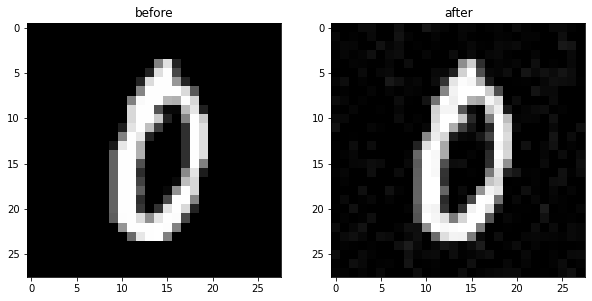

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(X_[2].reshape(28,28), cmap='gray'); ax[0].set_title('before')
ax[1].imshow(Xnew[2].reshape(28,28), cmap='gray'); ax[1].set_title('after');

### Phương pháp tăng cường dữ liệu bằng bằng cách xoay các hình

Các mẫu trong tập dữ liệu này có thể bị nghiêng, vì thế ta có thể tăng cường dữ liệu bằng cách sinh các mẫu khác với góc nghiêng khác nhau với hi vọng mô hình dự đoán chính xác được cho các mẫu bất kì trong tương lai. 
 

In [ ]:
from scipy.ndimage import rotate
IMAGE_SIZE = 28

class Random_Rotate_Img():
    def __init__(self, number_image=2, angle=(-30, 30), random_state=None):
        self.number_image = number_image
        self.angle = angle
        self.rng = np.random.default_rng(seed = random_state)
        pass
    
    def transform(self, X, y):
        X_ = X.copy()
        y_ = y.copy()
        if self.number_image < 1:
            return X_, y_

        (lowa, higha) = self.angle
        angles = self.rng.integers(low=lowa, high=higha, size=self.number_image)
        print('angles:', angles)

        X_augmented = []
        y_augmented = []

        for image, label in zip(X, y):
            X_augmented.append(image)
            y_augmented.append(label)

            for angle in angles:

                rot_img = rotate(image.reshape(-1, IMAGE_SIZE), angle, reshape=False).reshape([-1])
                rot_img[rot_img < 0] = 0

                X_augmented.append(rot_img)
                y_augmented.append(label)
        
        return np.array(X_augmented, dtype='float'), np.array(y_augmented, dtype='object')

In [ ]:
random_rot = Random_Rotate_Img(number_image=2, random_state=20)
X_aug, y_aug = random_rot.transform(X_, y_)

angles: [ 23 -14]


In [ ]:
X_aug.shape, y_aug.shape

((180000, 784), (180000,))

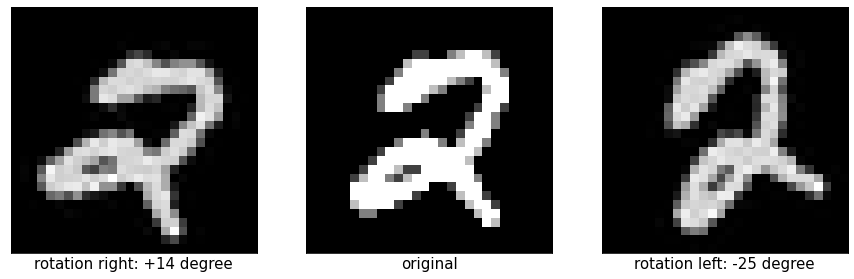

In [ ]:
f, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].imshow(X_aug[2].reshape(28, 28), cmap='gray');ax[0].set_xticks([]);ax[0].set_yticks([])
ax[0].set_xlabel(f"rotation right: +14 degree", fontsize=15)

ax[1].imshow(X_aug[0].reshape(28, 28), cmap='gray');ax[1].set_xticks([]);ax[1].set_yticks([])
ax[1].set_xlabel(f"original", fontsize=15)

ax[2].imshow(X_aug[1].reshape(28, 28), cmap='gray');ax[2].set_xticks([]);ax[2].set_yticks([]);
ax[2].set_xlabel(f"rotation left: -25 degree", fontsize=15);

### Phương pháp trích xuất đặc trưng

In [ ]:
def extract_hog(img, img_size=28, orientations=18, pixels_per_cell=(4, 4), cells_per_block=(3, 3)):
  fd = hog(img.reshape((img_size, img_size)), orientations=orientations, pixels_per_cell=pixels_per_cell, 
              cells_per_block=cells_per_block)
  return fd

In [ ]:
def edges_extraction(X, image_shape=(28,28)):
  fd_list = []
  for row in X:
      img = row.reshape(image_shape)
      fd = sobel(img.reshape(28,28))
      fd_list.append(fd)
  
  return np.array(fd_list)

In [ ]:
img=edges_extraction(X_)[0]

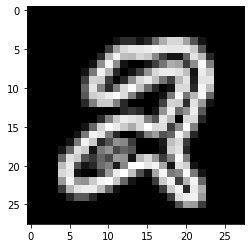

In [ ]:
plt.imshow(img, cmap='gray')

In [ ]:
class HOG_and_Sobel(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass
    
    def fit(self, X, y=None):
      return self
    
    def transform(self, X, y=None):
      X_ = X.copy()
      X_ = Parallel(n_jobs=os.cpu_count())(delayed(extract_hog)(img) for img in tqdm(X_))
      X_ = np.array(X_)
      #Todo sobel
      X_sobel = X.copy()
      X_sobel = edges_extraction(X_sobel)
      X_sobel = Parallel(n_jobs=os.cpu_count())(delayed(extract_hog)(img) for img in tqdm(X_sobel))
      X_sobel = np.array(X_sobel)
      #concat
      X_ = np.concatenate((X_, X_sobel), axis=1)
      return X_

# 3. Xây dựng mô hình Logistic Regression

Trước tiên ta sẽ tách 1 phần của tập huấn luyện ra để làm bộ validation (dùng trong cross-validation). 

Tách theo tỉ lệ 1/6 (10000 mẫu).

In [ ]:
np.random.seed(42)
nums = np.zeros(len(X_))
nums[:50000] = -1
np.random.shuffle(nums) 
val_fold = nums
ps = PredefinedSplit(test_fold=val_fold)

## 3.1 Mô hình cơ bản

Mô hình này không áp dụng các bước tiền xử lý như đã đề cập ở trên, ta chỉ muốn kiểm tra xem độ chính xác của mô hình cơ bản là bao nhiêu để tiến hành so sánh thôi. 


In [ ]:
full_pipeline = LogisticRegression()

param_grid = {'C':[0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(full_pipeline, param_grid,
                           scoring='accuracy',
                           cv=ps,
                           return_train_score=True, verbose=1)

grid_search.fit(X_, y_) 
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'Train accuracy: {train_score}, Validation accuracy: {test_score}, {params}')

Fitting 1 folds for each of 4 candidates, totalling 4 fits
Train accuracy: 0.93598, Validation accuracy: 0.9205, {'C': 0.01}
Train accuracy: 0.93612, Validation accuracy: 0.9207, {'C': 0.1}
Train accuracy: 0.93592, Validation accuracy: 0.9207, {'C': 1}
Train accuracy: 0.93592, Validation accuracy: 0.9207, {'C': 10}


In [ ]:
#Xem thông số tốt nhất
grid_search.best_params_

{'C': 0.1}

In [ ]:
#ước tính mô hình tốt nhất sau khi train
estimate_final_model = grid_search.best_estimator_
estimate_final_model.fit(X_,y_)

LogisticRegression(C=0.1)

In [ ]:
print(f"train + val:\t Accuracy: {estimate_final_model.score(X_, y_)}")
print(f"Test:       \t Accuracy: {estimate_final_model.score(X_test, y_test)}")

train + val:	 Accuracy: 0.93465
Test:       	 Accuracy: 0.9195


Mặc dù là mô hình cơ bản nhưng độ chính xác của nó cũng đã khá cao. Cũng dễ hiểu bởi vì bộ dữ liệu huấn luyện này cơ bản đã được chuẩn hóa, nên cũng không có gì nhiều để cải tiến.

## 3.2 Mô hình sử dụng loại bỏ các pixel vô nghĩa và giảm chiều

Thử nghiệm thứ 2 này sẽ dùng 2 phương pháp tiền xử lý cơ bản đó là loại bỏ các thuộc tính vô nghĩa và đa cộng tuyến sử dụng PCA.

In [ ]:
preprocess_pipeline = make_pipeline(drop_pixels, PCA(svd_solver= 'full'))

In [ ]:
full_pipeline = make_pipeline(preprocess_pipeline, LogisticRegression())

param_grid = { 'pipeline__pca__n_components': [0.9, 0.95, None],
              'logisticregression__C':[0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(full_pipeline, param_grid,
                           scoring='accuracy',
                           cv=ps,
                           return_train_score=True, verbose=1)

grid_search.fit(X_, y_) 
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'Train accuracy: {train_score}, Validation accuracy: {test_score}, {params}')

Fitting 1 folds for each of 12 candidates, totalling 12 fits
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 71
Number of useless pixel detected: 68
Train accuracy: 0.91446, Validation accuracy: 0.9119, {'logisticregression__C': 0.01, 'pipeline__pca__n_components': 0.9}
Train accuracy: 0.92318, Validation accuracy: 0.9173, {'logisticregression__C': 0.01, 'pipeline__pca__n_components': 0.95}
Train accuracy: 0.93736, Validation accuracy: 0.9147, {'logisticregression__C': 0.01, 'pipeline__pca__n_components': None}
Train accuracy: 0.9145, Validation accuracy: 0.9119, {'logisticregression__C': 0.1, 'pipel

In [ ]:
#Xem thông số tốt nhất
grid_search.best_params_

{'logisticregression__C': 0.1, 'pipeline__pca__n_components': 0.95}

In [ ]:
#ước tính mô hình tốt nhất sau khi train
estimate_final_model = grid_search.best_estimator_
estimate_final_model.fit(X_,y_)

Number of useless pixel detected: 68


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropuselesscol', DropUselessCol()),
                                 ('pca',
                                  PCA(n_components=0.95, svd_solver='full'))])),
                ('logisticregression', LogisticRegression(C=0.1))])

In [ ]:
print(f"train + val:\t Accuracy: {estimate_final_model.score(X_, y_)}")
print(f"Test:       \t Accuracy: {estimate_final_model.score(X_test, y_test)}")

train + val:	 Accuracy: 0.92265
Test:       	 Accuracy: 0.9142


Mô hình này cho ra kết quả thấp hơn của mô hình cơ bản. Có một cách để lý giải cho kết quả trên, đó là dữ liệu hình ảnh là dữ liệu đặc biệt, các điểm ảnh phải nằm gần nhau thì mới có ý nghĩa. Khi ta loại bỏ các cột cũng như là giảm chiều dữ liệu (bằng PCA) thì ta đã phá vỡ sự liên tục này. Vì thế nên kết quả không được tốt bằng mô hình cơ bản. 

##3.3 Mô hình sử dụng nhiễu

In [ ]:
preprocess_pipeline1 = make_pipeline(estimator_noise, PCA(svd_solver= 'full'))
full_pipeline = make_pipeline(preprocess_pipeline1, LogisticRegression())
 
param_grid = { 'pipeline__pca__n_components': [0.9, 0.95, None],
              'logisticregression__C':[0.01, 0.1, 1, 10]}
 
grid_search = GridSearchCV(full_pipeline, param_grid,
                           scoring='accuracy',
                           cv=ps,
                           return_train_score=True, verbose=1)
 
grid_search.fit(X_, y_) 
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'Train accuracy: {train_score}, Validation accuracy: {test_score}, {params}')

Fitting 1 folds for each of 12 candidates, totalling 12 fits
Train accuracy: 0.91514, Validation accuracy: 0.9134, {'logisticregression__C': 0.01, 'pipeline__pca__n_components': 0.9}
Train accuracy: 0.92352, Validation accuracy: 0.9142, {'logisticregression__C': 0.01, 'pipeline__pca__n_components': 0.95}
Train accuracy: 0.92826, Validation accuracy: 0.9096, {'logisticregression__C': 0.01, 'pipeline__pca__n_components': None}
Train accuracy: 0.91526, Validation accuracy: 0.9134, {'logisticregression__C': 0.1, 'pipeline__pca__n_components': 0.9}
Train accuracy: 0.92394, Validation accuracy: 0.9153, {'logisticregression__C': 0.1, 'pipeline__pca__n_components': 0.95}
Train accuracy: 0.92886, Validation accuracy: 0.9094, {'logisticregression__C': 0.1, 'pipeline__pca__n_components': None}
Train accuracy: 0.91506, Validation accuracy: 0.913, {'logisticregression__C': 1, 'pipeline__pca__n_components': 0.9}
Train accuracy: 0.92378, Validation accuracy: 0.9156, {'logisticregression__C': 1, 'pipe

In [ ]:
#Xem thông số tốt nhất
grid_search.best_params_

{'logisticregression__C': 10, 'pipeline__pca__n_components': 0.95}

In [ ]:
#ước tính mô hình tốt nhất sau khi train
estimate_final_model = grid_search.best_estimator_
estimate_final_model.fit(X_,y_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('random_noise_img',
                                  Random_Noise_Img(std=10.0)),
                                 ('pca',
                                  PCA(n_components=0.95, svd_solver='full'))])),
                ('logisticregression', LogisticRegression(C=10))])

In [ ]:
print(f"train + val:\t Accuracy: {estimate_final_model.score(X_, y_)}")
print(f"Test:       \t Accuracy: {estimate_final_model.score(X_test, y_test)}")

train + val:	 Accuracy: 0.9232833333333333
Test:       	 Accuracy: 0.9154


## 3.4 Mô hình sử dụng phương pháp tăng cường dữ liệu bằng cách xoay

Ta cũng dùng model tốt nhất chống noise kể trên để dùng với dữ liệu này:

In [ ]:
estimate_final_model_aug = estimate_final_model
estimate_final_model_aug.fit(X_aug,y_aug)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('random_noise_img',
                                  Random_Noise_Img(std=10.0)),
                                 ('pca',
                                  PCA(n_components=0.95, svd_solver='full'))])),
                ('logisticregression', LogisticRegression(C=10))])

In [ ]:
print(f"train + val:\t Accuracy: {estimate_final_model_aug.score(X_, y_)}")
print(f"Test:       \t Accuracy: {estimate_final_model_aug.score(X_test, y_test)}")

train + val:	 Accuracy: 0.8955666666666666
Test:       	 Accuracy: 0.8918


## 3.5 Mô hình sử dụng phương pháp trích xuất đặc trưng hog và sobel

In [ ]:
pipeline = make_pipeline(HOG_and_Sobel(), LogisticRegression(random_state=42))

param_grid = {'logisticregression__C':[0.01, 0.1, 1, 10]}

grid_search = GridSearchCV(pipeline, param_grid,
                           scoring='accuracy',
                           cv=ps,
                           return_train_score=True, verbose=1)

In [ ]:
grid_search.fit(X_, y_) 
cvres = grid_search.cv_results_
for train_score, test_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
    print(f'Train accuracy: {train_score}, Validation accuracy: {test_score}, {params}')

Fitting 1 folds for each of 4 candidates, totalling 4 fits


100%|██████████| 60000/60000 [01:12<00:00, 832.13it/s]


Train accuracy: 0.9776, Validation accuracy: 0.9739, {'logisticregression__C': 0.01}
Train accuracy: 0.99286, Validation accuracy: 0.9828, {'logisticregression__C': 0.1}
Train accuracy: 0.9998, Validation accuracy: 0.9827, {'logisticregression__C': 1}
Train accuracy: 1.0, Validation accuracy: 0.9815, {'logisticregression__C': 10}


In [ ]:
#Xem thông số tốt nhất
grid_search.best_params_

{'logisticregression__C': 0.1}

In [ ]:
#ước tính mô hình tốt nhất sau khi train
estimate_final_model = grid_search.best_estimator_
estimate_final_model.fit(X_,y_)

100%|██████████| 60000/60000 [01:15<00:00, 798.61it/s]


Pipeline(steps=[('hog_and_sobel', HOG_and_Sobel()),
                ('logisticregression',
                 LogisticRegression(C=0.1, random_state=42))])

In [ ]:
grid_search.score(X_test, y_test)

100%|██████████| 10000/10000 [00:11<00:00, 872.22it/s]


0.9814

Ta thấy đây là mô hình tốt nhất trong số các thử nghiệm, vậy ta sẽ lưu lại kết quả mô hình này để đem đi dự đoán trong tương lai.

In [ ]:
best_model = grid_search
joblib.dump(best_model, 'pickle_modelv2.pkl')

['pickle_modelv2.pkl']

---

# Tiến hành load mô hình lên lại để đánh giá:

In [ ]:
model = joblib.load('pickle_modelv2.pkl')

100%|██████████| 10000/10000 [00:13<00:00, 722.48it/s]


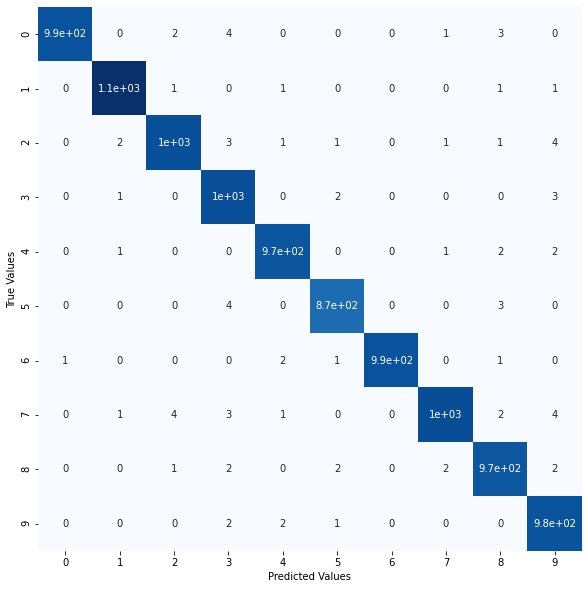

In [ ]:
fig = plt.figure(figsize=(10, 10))

y_pred = model.predict(X_[val_fold==0]) 

mat = confusion_matrix(y_[val_fold==0], y_pred)

sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [ ]:
print(classification_report(y_[val_fold==0], y_pred, target_names=np.unique(y_)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       990
           1       1.00      1.00      1.00      1141
           2       0.99      0.99      0.99      1010
           3       0.99      0.98      0.99      1023
           4       0.99      0.99      0.99       976
           5       0.99      0.99      0.99       881
           6       0.99      1.00      1.00       988
           7       0.99      1.00      0.99      1016
           8       0.99      0.99      0.99       979
           9       0.99      0.98      0.99       996

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# NEWEST TEST

In [ ]:
pipe = joblib.load('/pickle_modelv2.pkl')
tests = np.genfromtxt('/newtest.csv', delimiter=',')
tests.shape

(10000, 785)

In [ ]:
X, y = tests[:, 0:-1], tests[:, -1].astype('int').astype('str')
pipe.score(X, y)


100%|██████████| 10000/10000 [00:18<00:00, 528.60it/s]

100%|██████████| 10000/10000 [00:18<00:00, 539.14it/s]


0.9285

# Tổng kết

Model tốt nhất là model sử dụng phương pháp tiền xử lý Hog Sobel, với kết quả là `0.9814`.